In [1]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
from fractions import Fraction

In [26]:
with open('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/noisy_circuit/hpo_results/custom_cost_value_0.431926_timestamp_29-03-2024-17-23-08.pickle', 'rb') as f:
    new_hpo_config = pickle.load(f)

In [27]:
max(new_hpo_config['training_results']['fidelity_history'])

0.9989121725947278

In [28]:
new_hpo_config['runtime']/60

1.144583237171173

In [3]:
def filename_to_phi_gamma_tuple(filename):
    """
    Parses the given filename to extract phi and gamma values and returns them as a tuple.
    
    Args:
    filename (str): The filename to parse.
    
    Returns:
    tuple: A tuple containing the phi (in radians) and gamma values or None if parsing fails.
    """
    # Regex is no longer needed because the format is straightforward
    parts = filename.split('_')
    phi_part = parts[3]  # This gets the 'phi-VALUEpi' part
    gamma_part = parts[4]  # This gets the 'gamma-VALUE.pickle' part
    
    # Correctly parsing the phi value by removing 'phi-' prefix and then 'pi' before converting to float
    phi_value_str = phi_part[len('phi-'):].rstrip('pi')
    phi_value = float(phi_value_str) * 3.141592653589793  # Convert to radians by multiplying with pi
    
    # Extracting the gamma value, removing '.pickle' and converting to float
    gamma_value = float(gamma_part.split('-')[1].replace('.pickle', ''))
    
    return (phi_value, gamma_value)

def load_all_pickles(directory_path):
    # Create an empty dictionary to store the deserialized objects
    all_pickles = {}
    
    # List all files in the given directory
    for file in os.listdir(directory_path):
        # Check if the file is a pickle file
        if file.endswith(".pickle"):
            # Construct full file path
            file_path = os.path.join(directory_path, file)
            # Open the pickle file and load its content
            with open(file_path, 'rb') as pickle_file:
                # The file name (without extension) can be the dictionary key
                params_tuple = filename_to_phi_gamma_tuple(file)
                # Deserialize the object from file and add it to the dictionary
                all_pickles[params_tuple] = pickle.load(pickle_file)
                
    return {outer_key: list(inner_dict.values()) for outer_key, inner_dict in all_pickles.items()}

# Example usage:
# Replace 'your_directory_path_here' with the path to the directory containing your pickle files.
fidelity_results = load_all_pickles('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/noisy_circuit/multi_seed_results')

In [13]:
fidelity_results[0]

KeyError: 0

In [5]:
len(fidelity_results.keys())

12

In [6]:
list(fidelity_results[(0.7853981633974483, 0.01)][0].keys())

['avg_reward',
 'std_action',
 'fidelity_history',
 'action_history',
 'best_action_vector']

In [11]:
baseline_gate_fidelities = {
    (0.7853981633974483, 0.01): 0.9999938315170672,
    (0.7853981633974483, 0.025): 0.9999614476319376,
    (0.7853981633974483, 0.05): 0.9998457998168983,
    (1.5707963267948966, 0.01): 0.999975326306082,
    (1.5707963267948966, 0.025): 0.9998457998168983,
    (1.5707963267948966, 0.05): 0.999383347869602,
    (2.356194490192345, 0.01): 0.9999444850804711,
    (2.356194490192345, 0.025): 0.9996530844192801,
    (2.356194490192345, 0.05): 0.998613089769379,
    (3.141592653589793, 0.01): 0.9999013090292375,
    (3.141592653589793, 0.025): 0.999383347869602,
    (3.141592653589793, 0.05): 0.9975357675527649,
}

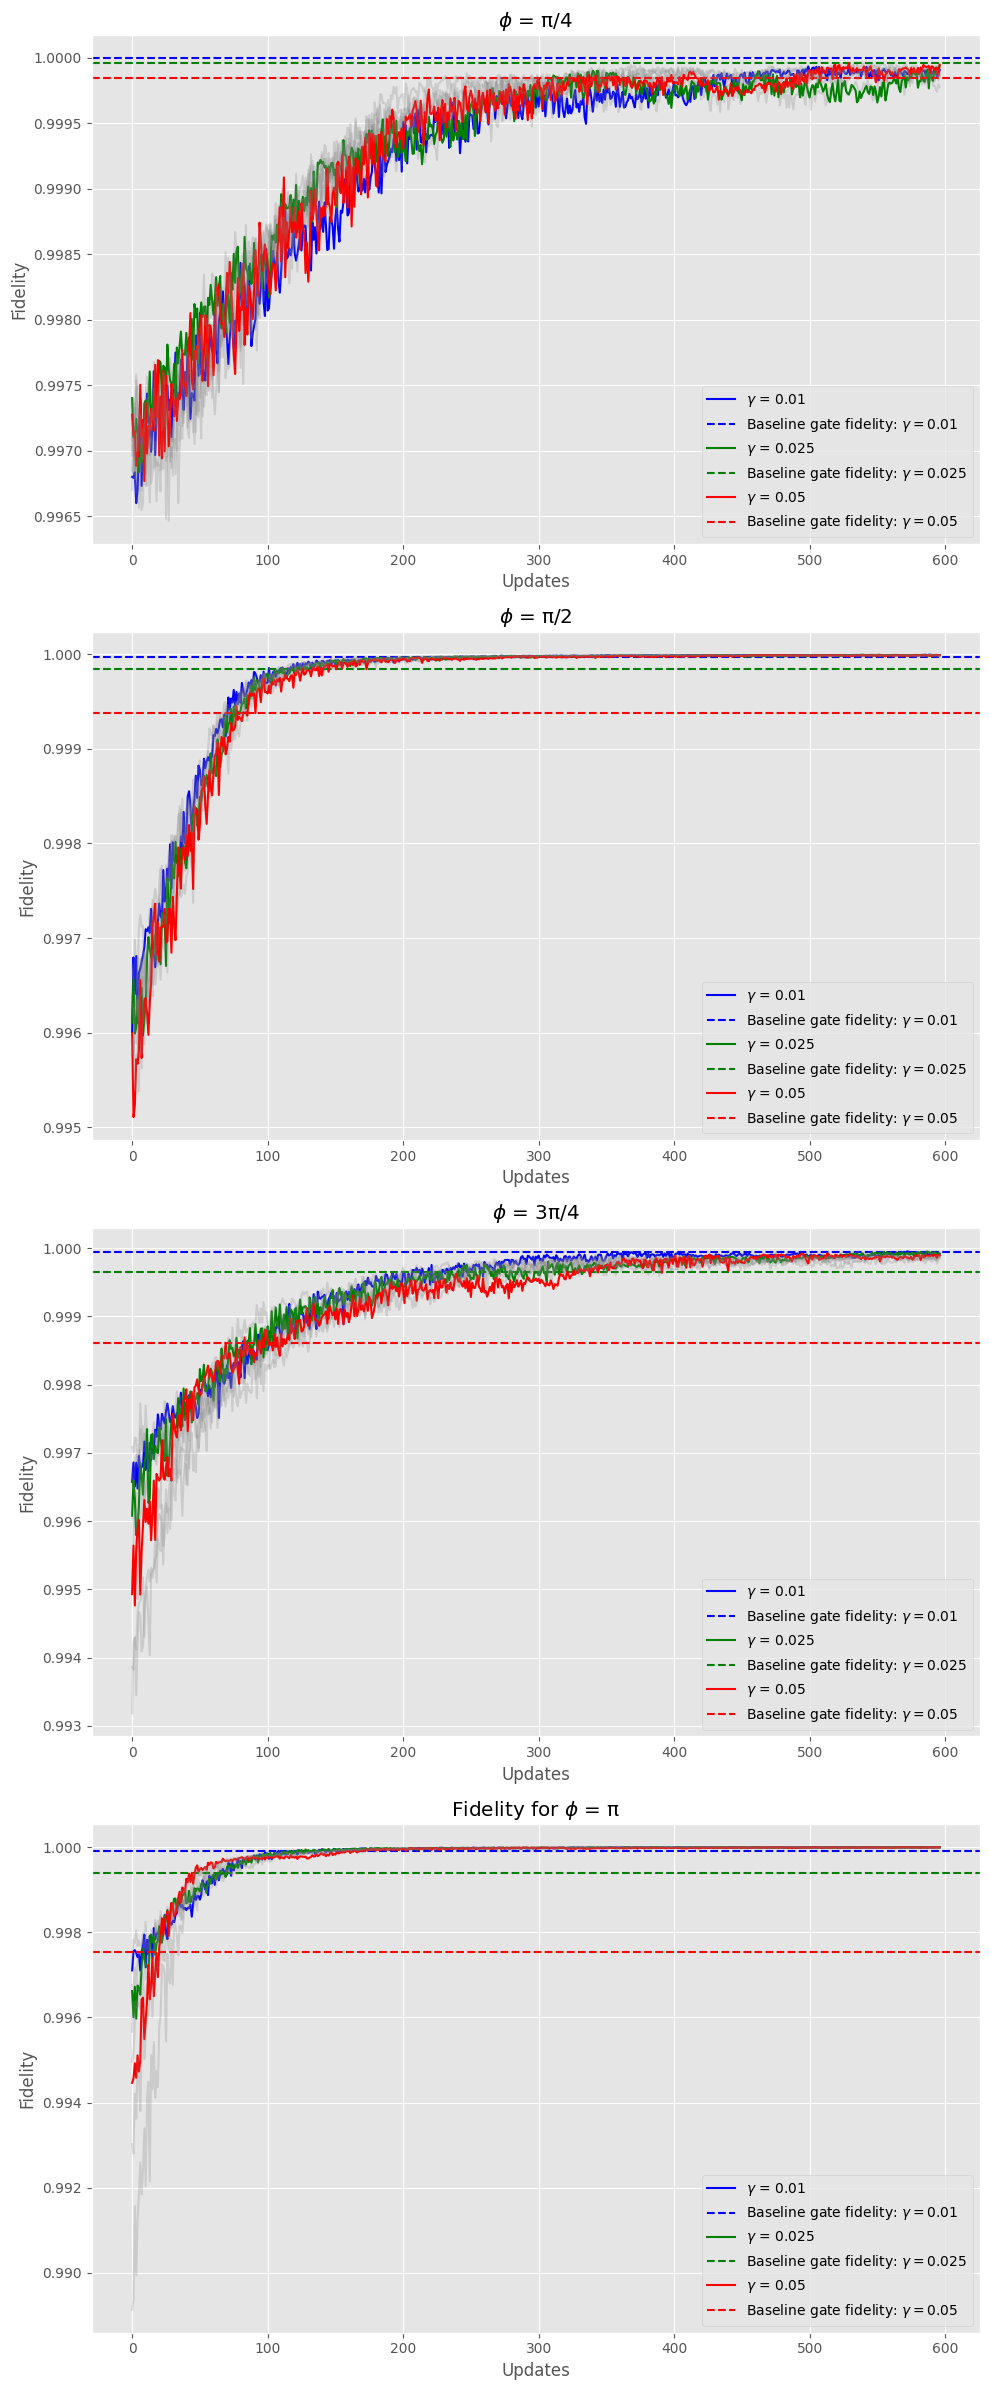

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from fractions import Fraction

# Set the style
plt.style.use('ggplot')

# Define colors for different gamma values for clarity in plotting
gamma_colors = {0.01: 'blue', 0.025: 'green', 0.05: 'red'}

# Assuming fidelity_results is populated as described
# Unique thetas for plotting
unique_phis = np.pi * np.array([0.25, 0.5, 0.75, 1.0])

# Plot fidelity results
fig, axs = plt.subplots(len(unique_phis), figsize=(10, 6 * len(unique_phis)), squeeze=False)
axs = axs.flatten()

for idx, phi in enumerate(unique_phis):
    # Keep track of plotted labels to avoid duplication in the legend
    plotted_labels = []
    for gamma, color in gamma_colors.items():
        if (phi, gamma) in fidelity_results:
            seed_results = fidelity_results[(phi, gamma)]
            max_value = max(seed_results, key=lambda x: x['fidelity_history'][-1])
            # Plot the best result for this gamma in its color
            axs[idx].plot(max_value['fidelity_history'], color=color, 
                          label=f'$\gamma$ = {gamma}' if f'$\gamma$ = {gamma}' not in plotted_labels else None)
            plotted_labels.append(f'$\gamma$ = {gamma}')
            # Plot the baseline gate fidelity as a horizontal line
            axs[idx].axhline(y=baseline_gate_fidelities[(phi, gamma)], color=color, linestyle='dashed',
                             label=f'Baseline gate fidelity: $\gamma={gamma}$' if 'Baseline gate fidelity' not in plotted_labels else None)
            # Plot other results in grey
            for result in seed_results:
                if result is not max_value:
                    axs[idx].plot(result['fidelity_history'], color='grey', alpha=0.25)

    # Setting titles and labels
    phi_fraction = Fraction(phi / np.pi).limit_denominator()
    numerator, denominator = phi_fraction.numerator, phi_fraction.denominator
    if numerator != 1 and denominator != 1:
        axs[idx].set_title(f'$\\phi$ = {numerator}π/{denominator}')
    elif denominator != 1:
        axs[idx].set_title(f'$\\phi$ = π/{denominator}')
    else:
        axs[idx].set_title(f'Fidelity for $\phi$ = π')
    axs[idx].set_xlabel('Updates')
    axs[idx].set_ylabel('Fidelity')
    axs[idx].legend()

plt.tight_layout()
plt.show()